# Calculating the Big Mac index

This R script shows how _The Economist_ calculates its Big Mac index.

We use the `tidyverse` and `data.table` packages for working with data generally.

In [1]:
library('tidyverse')
library('data.table')

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”
── Attaching packages ───────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ──────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




We only calculate the Big Mac index for certain countries, specifically these ones:

In [2]:
big_mac_countries = c('ARG', 'AUS', 'BRA', 'GBR', 'CAN', 'CHL', 'CHN', 'CZE', 'DNK',
                      'EGY', 'HKG', 'HUN', 'IDN', 'ISR', 'JPN', 'MYS', 'MEX', 'NZL',
                      'NOR', 'PER', 'PHL', 'POL', 'RUS', 'SAU', 'SGP', 'ZAF', 'KOR',
                      'SWE', 'CHE', 'TWN', 'THA', 'TUR', 'ARE', 'USA', 'COL', 'CRI',
                      'PAK', 'LKA', 'UKR', 'URY', 'IND', 'VNM', 'GTM', 'HND', # Venezuela removed
                      'NIC', 'AZE', 'BHR', 'HRV', 'JOR', 'KWT', 'LBN', 'MDA', 'OMN',
                      'QAT', 'ROU', 'EUZ')

Our raw data sheet, compiled every six months, contains three sets of data: the local price of a Big Mac, the exchange rate of the local currency to the US dollar, and the GDP per person of the country (in US dollars). We have these data compiled into a single file already, so we can just load it:

In [3]:
big_mac_data = fread('./source-data/big-mac-source-data.csv', na.strings = '#N/A') %>%
    .[!is.na(local_price)] %>%                    # remove lines where the local price is missing
    .[,GDP_dollar := as.numeric(GDP_dollar)] %>%  # convert GDP to a number
    .[order(date, name)]                          # sort by date and then by country name, for easy reading
tail(big_mac_data)

name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,date
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<date>
Turkey,TUR,TRY,14.99,7.47050,9150.862,2021-01-01
Ukraine,UKR,UAH,62.00,28.14000,3706.765,2021-01-01
United Arab Emirates,ARE,AED,14.75,3.67315,39179.883,2021-01-01
United States,USA,USD,5.66,1.00000,65253.518,2021-01-01
Uruguay,URY,UYU,204.00,42.49500,16110.742,2021-01-01
Vietnam,VNM,VND,66000.00,23064.00000,3416.232,2021-01-01


In [4]:
latest_date = big_mac_data$date %>% max
latest_date

[1] "2021-01-01"

### Converting to a uniform currency

Our first step to calculate the index is to convert all of the prices to a uniform currency (we use the US dollar).

In [5]:
big_mac_data[, dollar_price := local_price / dollar_ex]
tail(big_mac_data)

name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,date,dollar_price
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<date>,<dbl>
Turkey,TUR,TRY,14.99,7.47050,9150.862,2021-01-01,2.006559
Ukraine,UKR,UAH,62.00,28.14000,3706.765,2021-01-01,2.203269
United Arab Emirates,ARE,AED,14.75,3.67315,39179.883,2021-01-01,4.015627
United States,USA,USD,5.66,1.00000,65253.518,2021-01-01,5.660000
Uruguay,URY,UYU,204.00,42.49500,16110.742,2021-01-01,4.800565
Vietnam,VNM,VND,66000.00,23064.00000,3416.232,2021-01-01,2.861602


### Calculating the raw index

Now that we've done this, we can pick out our five 'base' currencies: the US dollar (USD), Euro (EUR), British pound (GBP), Japanese yen (JPY), and Chinese yuan (CNY).

In [6]:
base_currencies = c('USD', 'EUR', 'GBP', 'JPY', 'CNY')

Calculating the index is as simple as dividing the local price by the price in the base currency. We're using `data.table`'s grouping abilities to do this neatly.

In [7]:
big_mac_index = big_mac_data[
    !is.na(dollar_price) & iso_a3 %in% big_mac_countries
    ,.(date, iso_a3, currency_code, name, local_price, dollar_ex, dollar_price)]

for(currency in base_currencies) {
    big_mac_index[
        ,                           # we don't want a subset, so our first argument is blank
        (currency) :=               # we'll add a new column named for the base set
            dollar_price /          # we divide the dollar price in each row by
                                    # the dollar price on the *base currency*'s row (.SD is a data.table
            .SD[currency_code == currency]$dollar_price -        # that contains only the current group)
            1,                      # one means parity (neither over- nor under-valued), so we subtract one
                                    # to get an over/under-valuation value
        by=date                     # and of course, we'll group these rows by date
    ]
}
big_mac_index[, (base_currencies) := round(.SD, 5L), .SDcols=base_currencies]
tail(big_mac_index)

date,iso_a3,currency_code,name,local_price,dollar_ex,dollar_price,USD,EUR,GBP,JPY,CNY
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-01-01,TUR,TRY,Turkey,14.99,7.47050,2.006559,-0.64548,-0.61143,-0.54784,-0.46340,-0.41997
2021-01-01,UKR,UAH,Ukraine,62.00,28.14000,2.203269,-0.61073,-0.57334,-0.50351,-0.41079,-0.36311
2021-01-01,ARE,AED,United Arab Emirates,14.75,3.67315,4.015627,-0.29053,-0.22237,-0.09511,0.07387,0.16079
2021-01-01,USA,USD,United States,5.66,1.00000,5.660000,0.00000,0.09606,0.27543,0.51361,0.63612
2021-01-01,URY,UYU,Uruguay,204.00,42.49500,4.800565,-0.15184,-0.07037,0.08176,0.28378,0.38768
2021-01-01,VNM,VND,Vietnam,66000.00,23064.00000,2.861602,-0.49442,-0.44585,-0.35516,-0.23474,-0.17281


We can also see a basic plot, like so:

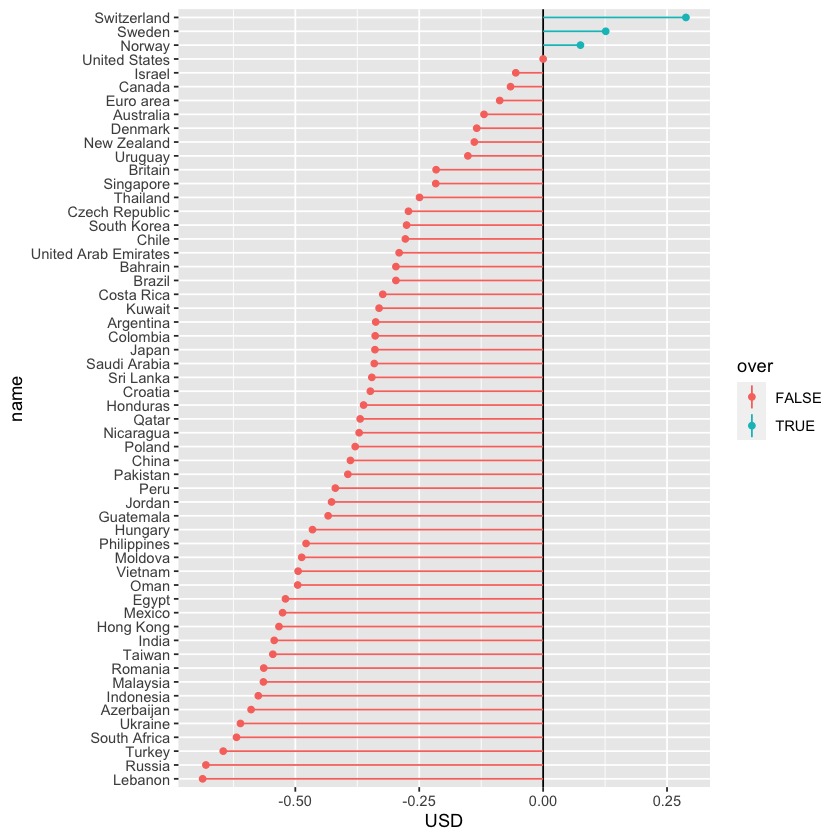

In [8]:
to_plot = big_mac_index[date == latest_date]
to_plot$name = factor(to_plot$name, levels=to_plot$name[order(to_plot$USD)])
ggplot(to_plot[, over := USD > 0], aes(x=name, y=USD, color=over)) +
    geom_hline(yintercept = 0) +
    geom_linerange(aes(ymin=0, ymax=USD)) +
    geom_point() +
    coord_flip()

We've now calculated the index. We'll save it to a file.

In [9]:
fwrite(big_mac_index, './output-data/big-mac-raw-index.csv')

Lovely! We've got it. So what about that adjusted index?

## Calculating the adjusted index

While the Big Mac index is a refreshingly simple way of thinking about relative currency values, a common (and fair) objection to it is that burgers cannot be easily traded across borders. Given non-traded local inputs (rent and worker’s wages) one would expect Big Macs to be cheaper in poorer countries and dearer in wealthier ones.

We'll start out by only picking the countries where we have GDP data.

In [10]:
big_mac_gdp_data = big_mac_data[GDP_dollar > 0]
head(big_mac_gdp_data)

name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,date,dollar_price
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<date>,<dbl>
Argentina,ARG,ARS,20.00,4.1325000,9138.177,2011-07-01,4.839685
Australia,AUS,AUD,4.56,0.9223816,55589.549,2011-07-01,4.943724
Austria,AUT,EUR,3.09,0.6975203,44986.583,2011-07-01,4.429979
Belgium,BEL,EUR,3.75,0.6975203,42630.113,2011-07-01,5.376188
Brazil,BRA,BRL,9.50,1.5416000,10816.487,2011-07-01,6.162429
Britain,GBR,GBP,2.39,0.6141374,36119.846,2011-07-01,3.891637


In order to correct for the problem, we'll use a linear regression of GDP vs Big Mac Price.

We sometimes add or remove countries from the Big Mac index, but we want the list of countries on which we base the adjusted index to remain consistent. We use this list of countries to calculate the relationship between GDP and Big Mac price:

In [11]:
regression_countries = c('ARG', 'AUS', 'BRA', 'GBR', 'CAN', 'CHL', 'CHN', 'CZE', 'DNK',
                         'EGY', 'EUZ', 'HKG', 'HUN', 'IDN', 'ISR', 'JPN', 'MYS', 'MEX',
                         'NZL', 'NOR', 'PER', 'PHL', 'POL', 'RUS', 'SAU', 'SGP', 'ZAF',
                         'KOR', 'SWE', 'CHE', 'TWN', 'THA', 'TUR', 'USA', 'COL', 'PAK',
                         'IND', 'AUT', 'BEL', 'NLD', 'FIN', 'FRA', 'DEU', 'IRL', 'ITA',
                         'PRT', 'ESP', 'GRC', 'EST')
# in 2021, we added a number of additional countries to the adjusted index
regression_addons_2021 = c('ARE', 'CRI', 'LKA', 'UKR', 'URY', 'VNM', 'GTM', 'HND', 'NIC',
                           'AZE', 'BHR', 'HRV', 'JOR', 'KWT', 'MDA', 'OMN', 'QAT', 'ROU',
                           'SVK', 'SVN', 'LVA', 'LTU')
big_mac_gdp_data = big_mac_gdp_data[iso_a3 %in% regression_countries |
  (iso_a3 %in% regression_addons_2021 & date >= as.Date('2021-01-01'))
]
tail(big_mac_gdp_data)

name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,date,dollar_price
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<date>,<dbl>
Turkey,TUR,TRY,14.99,7.47050,9150.862,2021-01-01,2.006559
Ukraine,UKR,UAH,62.00,28.14000,3706.765,2021-01-01,2.203269
United Arab Emirates,ARE,AED,14.75,3.67315,39179.883,2021-01-01,4.015627
United States,USA,USD,5.66,1.00000,65253.518,2021-01-01,5.660000
Uruguay,URY,UYU,204.00,42.49500,16110.742,2021-01-01,4.800565
Vietnam,VNM,VND,66000.00,23064.00000,3416.232,2021-01-01,2.861602


Now that we have our consistent basket of "regression countries", we can run our regressions. We can see what that looks like:

`geom_smooth()` using formula 'y ~ x'



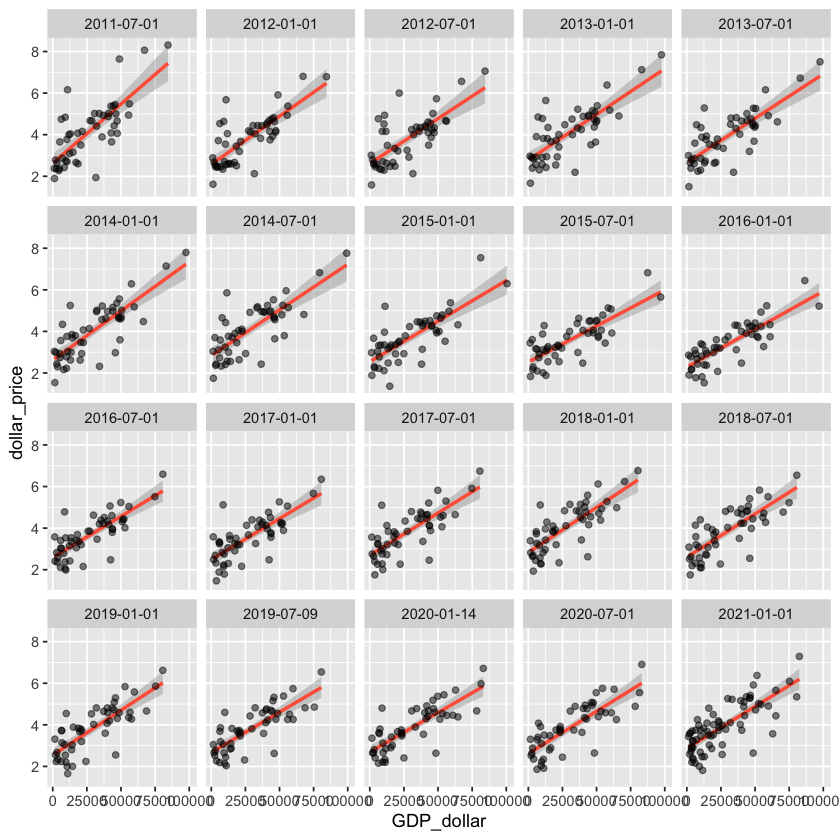

In [12]:
ggplot(big_mac_gdp_data, aes(x=GDP_dollar, y=dollar_price)) +
    facet_wrap(~date) +
    geom_smooth(method = lm, color='tomato') +
    geom_point(alpha=0.5)

We have to calculate the regressions separately for each date (ggplot did this for us above).

In [13]:
big_mac_gdp_data[,adj_price := lm(dollar_price ~ GDP_dollar) %>% predict,by=date]
tail(big_mac_gdp_data)

name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,date,dollar_price,adj_price
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>
Turkey,TUR,TRY,14.99,7.47050,9150.862,2021-01-01,2.006559,3.233903
Ukraine,UKR,UAH,62.00,28.14000,3706.765,2021-01-01,2.203269,3.014204
United Arab Emirates,ARE,AED,14.75,3.67315,39179.883,2021-01-01,4.015627,4.445737
United States,USA,USD,5.66,1.00000,65253.518,2021-01-01,5.660000,5.497949
Uruguay,URY,UYU,204.00,42.49500,16110.742,2021-01-01,4.800565,3.514772
Vietnam,VNM,VND,66000.00,23064.00000,3416.232,2021-01-01,2.861602,3.002480


If we've done everything right, all the points we just generated should be on those lines from above...

`geom_smooth()` using formula 'y ~ x'



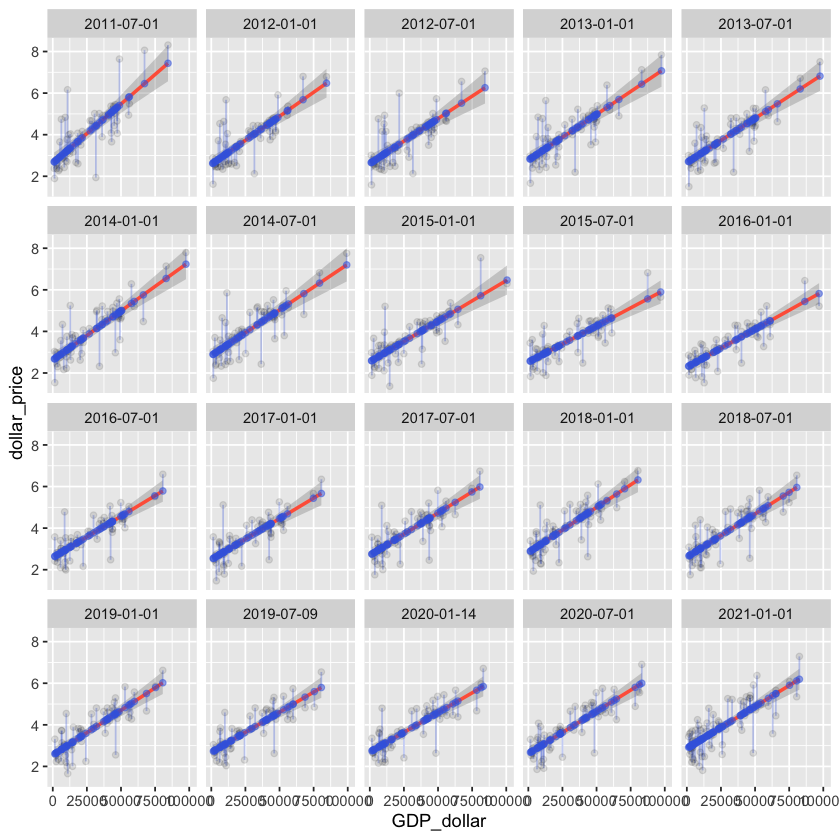

In [14]:
ggplot(big_mac_gdp_data, aes(x=GDP_dollar, y=dollar_price)) +
    facet_wrap(~date) +
    geom_smooth(method = lm, color='tomato') +
    geom_linerange(aes(ymin=dollar_price, ymax=adj_price), color='royalblue', alpha=0.3) +
    geom_point(alpha=0.1) +
    geom_point(aes(y=adj_price), color='royalblue', alpha=0.5)

Yep, that's exactly what we wanted. So now that we've got these data, we can do almost the same thing as before.

In [15]:
big_mac_adj_index = big_mac_gdp_data[
    !is.na(dollar_price) &
    (
        iso_a3 %in% regression_countries |
        iso_a3 %in% regression_addons_2021 & date >= '2021-01-01'
    ) &
    iso_a3 %in% big_mac_countries
    ,.(date, iso_a3, currency_code, name, local_price, dollar_ex, dollar_price, GDP_dollar, adj_price)]

for(currency in base_currencies) {
    big_mac_adj_index[
        ,                           # we don't want a subset, so our first argument is blank
        (currency) :=               # we'll add a new column named for the base set
            (                       # we divide the dollar price by the adjusted price to get
                dollar_price / adj_price  # the deviation from our expectation by
            ) /
                                    # the same figure from the *base currency*'s rowa\
            (
                .SD[currency_code == currency]$dollar_price /
                .SD[currency_code == currency]$adj_price
            ) -
            1,                      # one means parity (neither over- nor under-valued), so we subtract one
                                    # to get an over/under-valuation value
        by=date                     # and of course, we'll group these rows by date
    ]
}
big_mac_adj_index[, (base_currencies) := round(.SD, 5L), .SDcols=base_currencies]

tail(big_mac_adj_index)

date,iso_a3,currency_code,name,local_price,dollar_ex,dollar_price,GDP_dollar,adj_price,USD,EUR,GBP,JPY,CNY
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-01-01,TUR,TRY,Turkey,14.99,7.47050,2.006559,9150.862,3.233903,-0.39729,-0.46486,-0.36035,-0.25512,-0.41175
2021-01-01,UKR,UAH,Ukraine,62.00,28.14000,2.203269,3706.765,3.014204,-0.28997,-0.36957,-0.24645,-0.12248,-0.30700
2021-01-01,ARE,AED,United Arab Emirates,14.75,3.67315,4.015627,39179.883,4.445737,-0.12261,-0.22097,-0.06884,0.08436,-0.14366
2021-01-01,USA,USD,United States,5.66,1.00000,5.660000,65253.518,5.497949,0.00000,-0.11211,0.06128,0.23589,-0.02399
2021-01-01,URY,UYU,Uruguay,204.00,42.49500,4.800565,16110.742,3.514772,0.32672,0.17798,0.40802,0.63968,0.29489
2021-01-01,VNM,VND,Vietnam,66000.00,23064.00000,2.861602,3416.232,3.002480,-0.07421,-0.17800,-0.01747,0.14418,-0.09642


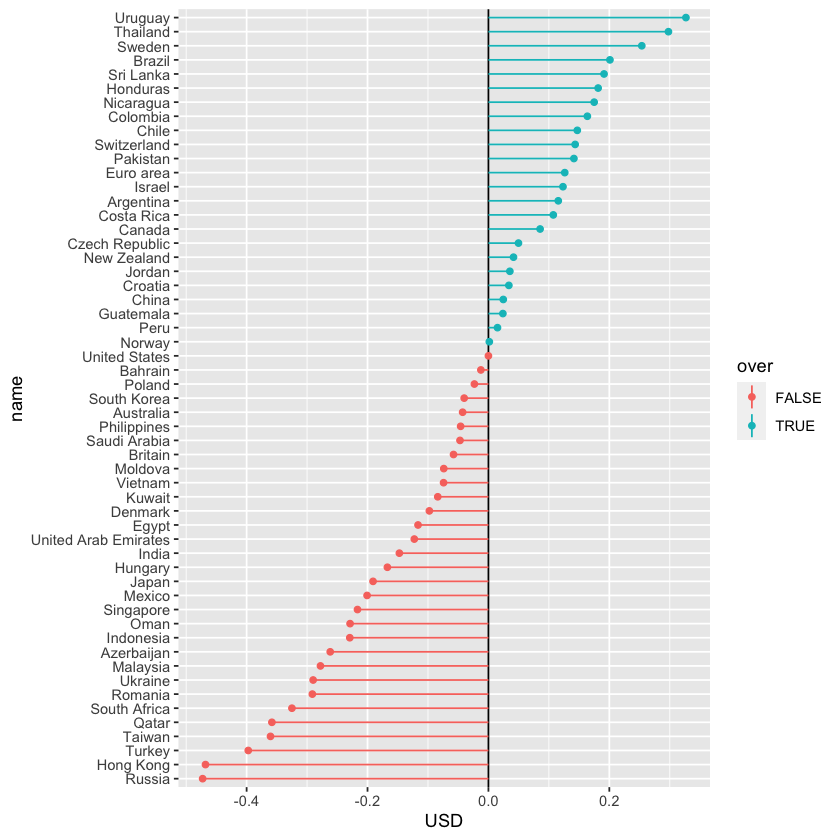

In [16]:
to_plot = big_mac_adj_index[date == latest_date]
to_plot$name = factor(to_plot$name, levels=to_plot$name[order(to_plot$USD)])
ggplot(to_plot[, over := USD > 0], aes(x=name, y=USD, color=over)) +
    geom_hline(yintercept = 0) +
    geom_linerange(aes(ymin=0, ymax=USD)) +
    geom_point() +
    coord_flip()

In [17]:
fwrite(big_mac_adj_index, './output-data/big-mac-adjusted-index.csv')

Also, for tidiness, we'll generate a consolidated file with both indices in one table.

In [18]:
big_mac_full_index = merge(big_mac_index, big_mac_adj_index,
      by=c('date', 'iso_a3', 'currency_code', 'name', 'local_price', 'dollar_ex', 'dollar_price'),
      suffixes=c('_raw', '_adjusted'),
      all.x=TRUE
     )
tail(big_mac_full_index)

date,iso_a3,currency_code,name,local_price,dollar_ex,dollar_price,USD_raw,EUR_raw,GBP_raw,JPY_raw,CNY_raw,GDP_dollar,adj_price,USD_adjusted,EUR_adjusted,GBP_adjusted,JPY_adjusted,CNY_adjusted
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-01-01,TWN,TWD,Taiwan,72.00,27.9800,2.573267,-0.54536,-0.50169,-0.42014,-0.31185,-0.25615,25873.367,3.908747,-0.36051,-0.43221,-0.32132,-0.20966,-0.37586
2021-01-01,UKR,UAH,Ukraine,62.00,28.1400,2.203269,-0.61073,-0.57334,-0.50351,-0.41079,-0.36311,3706.765,3.014204,-0.28997,-0.36957,-0.24645,-0.12248,-0.30700
2021-01-01,URY,UYU,Uruguay,204.00,42.4950,4.800565,-0.15184,-0.07037,0.08176,0.28378,0.38768,16110.742,3.514772,0.32672,0.17798,0.40802,0.63968,0.29489
2021-01-01,USA,USD,United States,5.66,1.0000,5.660000,0.00000,0.09606,0.27543,0.51361,0.63612,65253.518,5.497949,0.00000,-0.11211,0.06128,0.23589,-0.02399
2021-01-01,VNM,VND,Vietnam,66000.00,23064.0000,2.861602,-0.49442,-0.44585,-0.35516,-0.23474,-0.17281,3416.232,3.002480,-0.07421,-0.17800,-0.01747,0.14418,-0.09642
2021-01-01,ZAF,ZAR,South Africa,33.50,15.5225,2.158158,-0.61870,-0.58207,-0.51368,-0.42286,-0.37615,5977.954,3.105859,-0.32503,-0.40070,-0.28367,-0.16581,-0.34122


In [19]:
fwrite(big_mac_full_index, './output-data/big-mac-full-index.csv')